# Part 1

## SOL Emotional detection 

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 
import string
import re
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
# Classifiers
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
# Performance Matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

In [3]:
root_path = "C://Users//HP//Documents//perceptron//SOL Health AI"
resource_root_path = "C://Users//HP//Documents//perceptron//SOL Health AI//data"

In [4]:
#read data file
df = pd.read_csv('data/Chatbot Dataset.csv',encoding='ISO-8859-1')
df = df.dropna(axis=0)
#remove dupicates
df_unduplicate = df.drop_duplicates(keep=False,inplace=False)
df_unduplicate

,User,Chatbot,Intent
0,Hello,Hi <HUMAN> how are you?,Greeting
1,Hi,Hello <HUMAN> how are you?,Greeting
2,Hola,Hi <HUMAN> how are you?,Greeting
3,Hi there,Hi <HUMAN> how are you?,Greeting
4,Hya there,Hi <HUMAN> how are you?,Greeting
...,...,...,...
2295,Today I meditated for 30 minutes and I feel am...,I am glad you felt better after meditating,Surprise_Amazed
2296,I broke my foot,I am sorry to hear your foot broke,Health
2297,I broke my foot,I am sorry to hear you broke your foot,Health
2298,My boss gave me priase in front of the group a...,I am glad your work was praised,Happy_Excited_Joy


In [5]:
#show data shape and columns
print('Dataset size:',df.shape)
print('Columns are:',df.columns)
Y = df['Intent']

Dataset size: (2064, 3)
Columns are: Index(['User', 'Chatbot', 'Intent'], dtype='object')


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2064 entries, 0 to 2299
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   User     2064 non-null   object
 1   Chatbot  2064 non-null   object
 2   Intent   2064 non-null   object
dtypes: object(3)
memory usage: 64.5+ KB


In [7]:
#show intents in document and occurence
counter=collections.Counter(df['Intent'])
counter

Counter({'Greeting': 25,
         'Introduction': 80,
         'Info': 255,
         'Confirm': 190,
         'Time': 11,
         'Farewell': 13,
         'Happy_Excited_Joy': 372,
         'Surprise_Amazed': 58,
         'Age': 10,
         'HowAreYou': 13,
         'Good': 15,
         'Sad': 404,
         'Health': 138,
         'Meet/Talk': 11,
         'Sorry': 25,
         'Thanks': 33,
         'Compliment': 28,
         'Angry_Frustrated': 93,
         'Busy': 34,
         'Origin': 18,
         'Joke': 16,
         'Sleep': 16,
         'Eat_Food': 91,
         'Love': 57,
         'Hobby': 23,
         'Insult': 29,
         'Jealous': 6})

## text pre-processing

### Removing punctuations from data file


In [8]:
#xchar are special characters in text such as emojis for uniformity 
xchar = pd.read_csv('data/Xchar.txt',sep=',',header=None)
xchar_dict = {i:j for i,j in zip(xchar[0],xchar[1])}
pattern = '|'.join(sorted(re.escape(k) for k in xchar_dict))

def replace_xchar(text):
    text = re.sub(pattern,lambda m: xchar_dict.get(m.group(0)), text, flags=re.IGNORECASE)
    return text

def remove_punct(text):
    text = replace_xchar(text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

In [9]:
#import contraction dictionary 
#removing and reconstracting all the shortened words in file and replacing them with their full writen form allowing sentiment analysis
import json
with open('data/contractionDic.json') as f:
    cont_data = f.read()
js = json.loads(cont_data) 
print("Data type after reconstruction : ", type(js))
print(js) 

contraction_dict = json.loads(cont_data)
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

Data type after reconstruction :  <class 'dict'>
{"ain't": 'is not', "aren't": 'are not', "can't": 'cannot', "'cause": 'because', "could've": 'could have', "couldn't": 'could not', "didn't": 'did not', "doesn't": 'does not', "don't": 'do not', "hadn't": 'had not', "hasn't": 'has not', "haven't": 'have not', "he'd": 'he would', "he'll": 'he will', "he's": 'he is', "how'd": 'how did', "how'd'y": 'how do you', "how'll": 'how will', "how's": 'how is', "I'd": 'I would', "I'd've": 'I would have', "I'll": 'I will', "I'll've": 'I will have', "I'm": 'I am', 'im': 'i am', "I've": 'I have', "i'd": 'i would', "i'd've": 'i would have', "i'll": 'i will', "i'll've": 'i will have', "i'm": 'i am', "i've": 'i have', "isn't": 'is not', "it'd": 'it would', "it'd've": 'it would have', "it'll": 'it will', "it'll've": 'it will have', "it's": 'it is', "let's": 'let us', "ma'am": 'madam', "mayn't": 'may not', "might've": 'might have', "mightn't": 'might not', "mightn't've": 'might not have', "must've": 'must h

### Tokenization 

In [10]:
#breaking apart original text into individual pieces for further analysis
def tokenization(text):
    text = text.lower()
    text = re.split('\W+', text)
    return text

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stopword = nltk.corpus.stopwords.words('english')
stopword.extend(['patients', 'may','day', 'case','old','u','n','didnt','yr', 'year', 'woman', 'man', 'girl','boy',
                 'brother','dad','one', 'two', 'sixteen', 'yearold', 'fu', 'weeks', 'week',
              'treatment', 'associated','ive','ate','feel','keep'
                'basic','im'])
#remove all stop words
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

In [13]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
#lemmatization is used to normalize text and prepare words and documents for further processing in Machine Learning
Wlament = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [Wlament.lemmatize(word) for word in text]
    return text
#text cleaning
def clean_text(text):
    text = replace_contractions(text)
    text = remove_punct(text)
    text = tokenization(text)
    # text = remove_stopwords(text)
    text = lemmatizer(text)
    return text

## using count vector and term frequency for feature extraction 

Encoded sample is:
[[0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0]
 [0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1]
 [0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 2 0]]
['cat', 'cows', 'dog', 'drink', 'fire', 'flies', 'fring', 'home', 'into', 'landed', 'milk', 'of', 'out', 'pan', 'talking', 'that', 'the', 'went']


<AxesSubplot:>

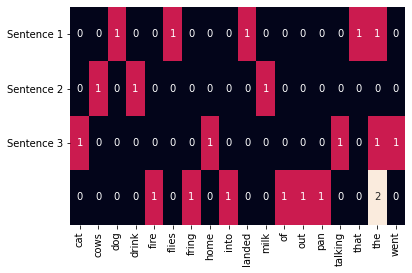

In [15]:
#count vectorizer
#Creating a matrix for each word with a unique column matrix represented in a table where the value of each cell is the count of each word

sample =['the dog that flies landed', 'cows drink milk', 'the talking cat went home', 'out of the fring pan into the fire'] #upsard sentenses 

# Create a Vectorizer Object
vectorizer = CountVectorizer()
vectorizer.fit(sample)
# Encode the Document
vector = vectorizer.transform(sample)

print("Encoded sample is:")
print(vector.toarray())

sample_out = sorted(vectorizer.vocabulary_)

print(sample_out)

sns.heatmap(vector.toarray(), annot=True, cbar=False, xticklabels=sample_out,
                                             yticklabels=['Sentence 1','Sentence 2','Sentence 3'])

[[0.47952794 0.         0.47952794 0.47952794 0.         0.
  0.         0.         0.47952794 0.         0.         0.
  0.         0.28321692 0.        ]
 [0.         0.47952794 0.         0.         0.         0.
  0.47952794 0.         0.         0.         0.         0.
  0.47952794 0.28321692 0.47952794]
 [0.         0.         0.         0.         0.36772387 0.36772387
  0.         0.36772387 0.         0.36772387 0.36772387 0.36772387
  0.         0.43436728 0.        ]]
{'cows': 2, 'drink': 3, 'all': 0, 'the': 13, 'milk': 8, 'talking': 12, 'cat': 1, 'went': 14, 'home': 6, 'out': 10, 'of': 9, 'fring': 5, 'pan': 11, 'into': 7, 'fire': 4}
['all', 'cat', 'cows', 'drink', 'fire', 'fring', 'home', 'into', 'milk', 'of', 'out', 'pan', 'talking', 'the', 'went']


<AxesSubplot:>

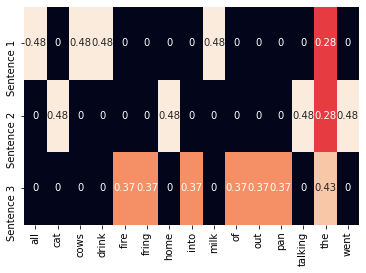

In [16]:
#Term frequency using inverse document frequency 
#the measure of how requently a term appears

from sklearn.feature_extraction.text import TfidfVectorizer
sample =['cows drink all the milk', 'the talking cat went home', 'out of the fring pan into the fire'] #upsard sentenses

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(sample).toarray()

print (tfidf)

print (tfidf_vectorizer.vocabulary_)

sorted_sample = sorted(tfidf_vectorizer.vocabulary_)

print(sorted_sample)
sns.heatmap(tfidf, annot=True, cbar=False, xticklabels=sorted_sample,
                                           yticklabels=['Sentence 1','Sentence 2','Sentence 3'])

In [17]:
#split training data into two and Apply feature extraction
X_train, X_test, y_train, y_test = train_test_split(df['User'], df['Intent'],test_size=0.25, random_state = 31)

countVectorizer1 = CountVectorizer(analyzer=clean_text)
countVector1 = countVectorizer1.fit_transform(X_train)

countVector2 = countVectorizer1.transform(X_test)

tfidf_transformer_xtrain = TfidfTransformer()
x_train = tfidf_transformer_xtrain.fit_transform(countVector1)

tfidf_transformer_xtest = TfidfTransformer()
x_test = tfidf_transformer_xtest.fit_transform(countVector2)

# models

In [18]:
#using svm (support vector machine) and mlp (multi layer perceptron) to perform accuracy, recall, precision and F1-score

#svm

svm = SGDClassifier()
svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)

svm_acc = accuracy_score(y_pred, y_test)
svm_prec = precision_score(y_test, y_pred, average='macro')
svm_recal = recall_score(y_test, y_pred, average='macro')
svm_cm = confusion_matrix(y_test,y_pred)
svm_f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', '{0:.3f}'.format(svm_acc*100))
print('Precision:', '{0:.3f}'.format(svm_prec*100))
print('Recall:', '{0:.3f}'.format(svm_recal*100))
print('F1-score:', '{0:.3f}'.format(svm_f1*100))
print(classification_report(y_test,y_pred))

Accuracy: 71.512
Precision: 66.904
Recall: 58.971
F1-score: 60.467
                   precision    recall  f1-score   support

              Age       0.50      0.50      0.50         2
 Angry_Frustrated       0.83      0.58      0.68        26
             Busy       0.67      0.57      0.62         7
       Compliment       0.40      0.33      0.36         6
          Confirm       0.61      0.58      0.60        53
         Eat_Food       0.65      0.81      0.72        16
         Farewell       1.00      0.33      0.50         3
             Good       0.33      0.20      0.25         5
         Greeting       1.00      0.29      0.44         7
Happy_Excited_Joy       0.79      0.97      0.87        87
           Health       0.93      0.72      0.81        39
            Hobby       0.67      0.50      0.57         4
        HowAreYou       0.33      0.33      0.33         3
             Info       0.66      0.64      0.65        64
           Insult       0.75      0.75      0.7

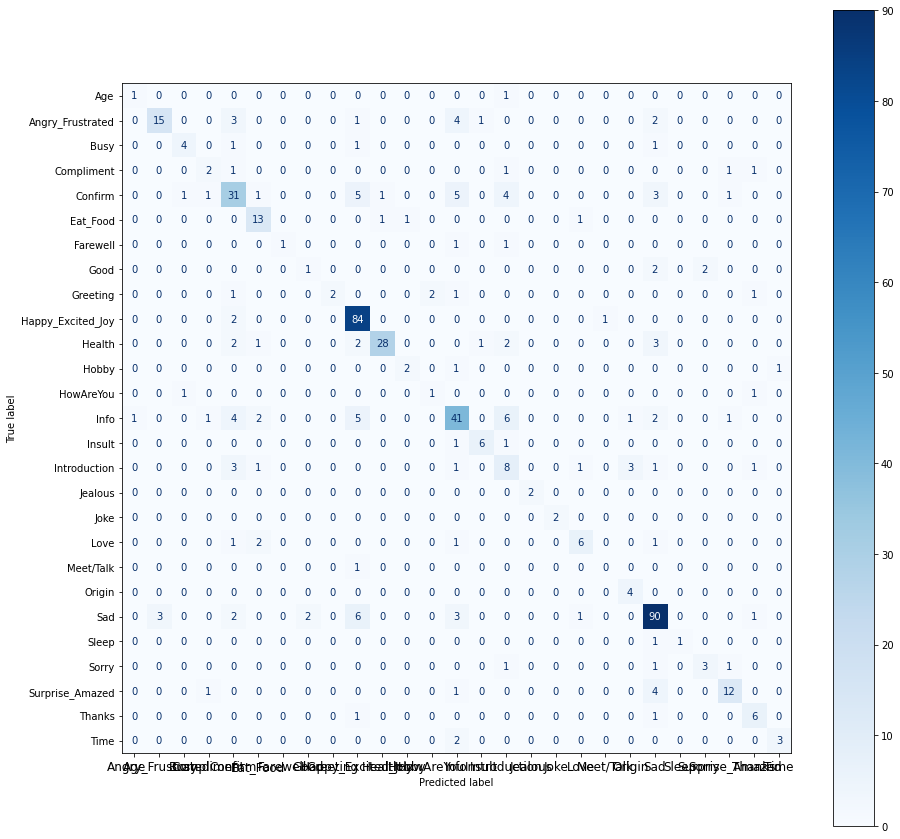

In [19]:
# visualization of confusion matrix for svm

cm_display_svm = ConfusionMatrixDisplay(svm_cm, display_labels=svm.classes_)
fig, ax = plt.subplots(figsize=(15,15)) 
ax.set_xticklabels(svm.classes_, rotation='vertical', fontsize=12)
cm_display_svm.plot(ax=ax,cmap='Blues')

In [30]:
#mlp
mlp = MLPClassifier(random_state=5, max_iter=100)
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)

mlp_acc = accuracy_score(y_pred, y_test)
mlp_prec = precision_score(y_test, y_pred, average='macro')
mlp_recal = recall_score(y_test, y_pred, average='macro')
mlp_cm = confusion_matrix(y_test,y_pred)
mlp_f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', '{0:.3f}'.format(mlp_acc*100))
print('Precision:', '{0:.3f}'.format(mlp_prec*100))
print('Recall:', '{0:.3f}'.format(mlp_recal*100))
print('F1-score:', '{0:.3f}'.format(mlp_f1*100))
print(classification_report(y_test,y_pred))

Accuracy: 70.349
Precision: 73.791
Recall: 53.342
F1-score: 59.048
                   precision    recall  f1-score   support

              Age       1.00      0.50      0.67         2
 Angry_Frustrated       0.74      0.54      0.62        26
             Busy       0.75      0.43      0.55         7
       Compliment       0.67      0.33      0.44         6
          Confirm       0.56      0.53      0.54        53
         Eat_Food       0.72      0.81      0.76        16
         Farewell       1.00      0.33      0.50         3
             Good       0.33      0.20      0.25         5
         Greeting       1.00      0.43      0.60         7
Happy_Excited_Joy       0.74      0.97      0.84        87
           Health       0.84      0.69      0.76        39
            Hobby       0.50      0.50      0.50         4
        HowAreYou       0.25      0.33      0.29         3
             Info       0.65      0.69      0.67        64
           Insult       1.00      0.62      0.7

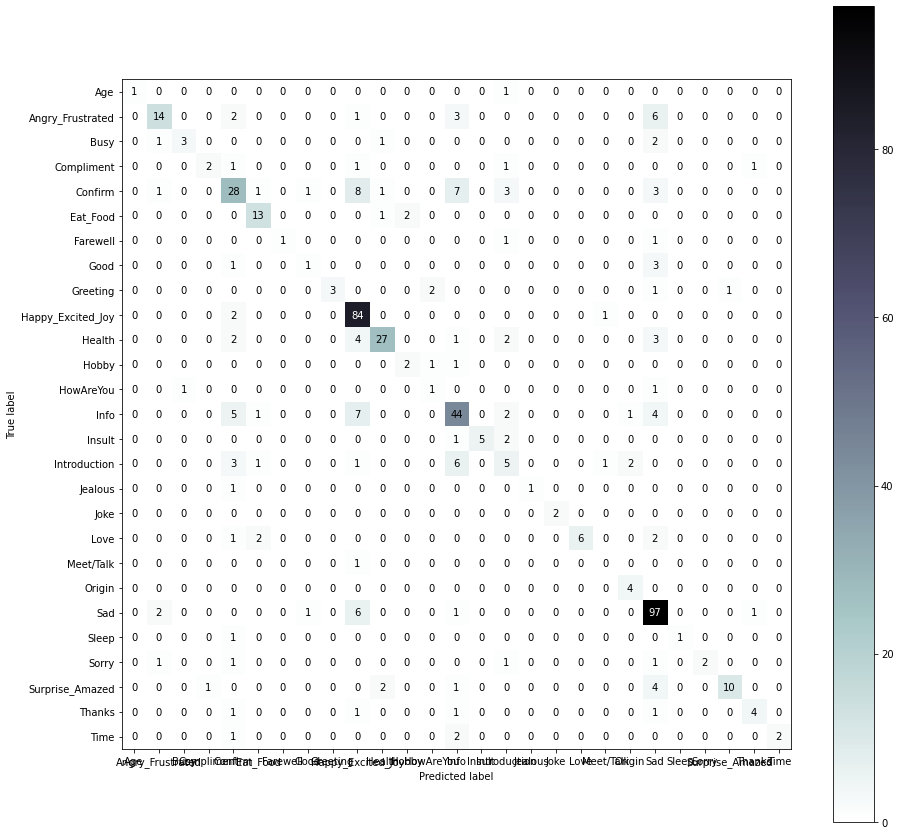

In [31]:
# visualization of confusion matrix for mlp
cm_display_mlp = ConfusionMatrixDisplay(mlp_cm, display_labels=mlp.classes_)
fig, ax = plt.subplots(figsize=(15,15)) 
cm_display_mlp.plot(ax=ax,cmap='bone_r')

In [32]:
#function to determin the percenteage of each emotional call made by the bot when interacting
def get_percentage_emotinal_call(cm):
    per_emotion_precision = []
    for i in range(len(cm)):
        count_per_emotion,accurate = 0,0
        for j in range(len(cm)):
            if i == j:
                accurate = cm[j][i]
            count_per_emotion += cm[j][i]
        per_emotion_precision.append(round((accurate/count_per_emotion)*100,3))
        
    per_emotion_recall = []
    for i in range(len(cm)):
        count_per_emotion,accurate = 0,0
        for j in range(len(cm)):
            if i == j:
                accurate = cm[i][j]
            count_per_emotion += cm[i][j]
        per_emotion_recall.append(round((accurate/count_per_emotion)*100,3))
        
    return per_emotion_precision, per_emotion_recall

#get precision of each model
svm_per_prec,svm_per_recall = get_percentage_emotinal_call(svm_cm)
mlp_per_prec,mlp_per_recall = get_percentage_emotinal_call(mlp_cm)
#recal the models used
per_precision_list = pd.DataFrame({'Support vector Machine' : svm_per_prec, 'Multi Layer Perceptron' : mlp_per_prec}, 
                                index=svm.classes_)
per_precision_list

print(len(set(y_test)))
import collections
counter=collections.Counter(y_test)
counter

27


Counter({'Sad': 108,
         'Health': 39,
         'Confirm': 53,
         'Insult': 8,
         'Info': 64,
         'Introduction': 19,
         'Happy_Excited_Joy': 87,
         'Angry_Frustrated': 26,
         'Meet/Talk': 1,
         'Hobby': 4,
         'Time': 5,
         'Surprise_Amazed': 18,
         'Busy': 7,
         'Compliment': 6,
         'Greeting': 7,
         'Sorry': 6,
         'Sleep': 2,
         'Eat_Food': 16,
         'Good': 5,
         'Jealous': 2,
         'Thanks': 8,
         'Farewell': 3,
         'Love': 11,
         'HowAreYou': 3,
         'Origin': 4,
         'Age': 2,
         'Joke': 2})

In [33]:
#save the models to disk
with open(root_path+'/models/Chatbot_Model_final.pkl') as f:
    pickle.dump([svm, mlp], f)

TypeError: write() argument must be str, not bytes

In [34]:
#load models from disc
if os.path.isfile(root_path+'/models/Chatbot_Model_final.pkl'):
    # Getting back the objects:
    with open(root_path+'/models/Chatbot_Model_final.pkl','rb') as f:  
        svm, mlp = pickle.load(f)
        print('File was Loaded Successfully')
else:
    print('File can not be Found')

File was Loaded Successfully



# make predictions

In [35]:
import random
def response_generator(text, intent_name):
    reply = response(text, intent_name)

    return reply

def recall_countvectorizer(s1, s2):
    
    # turn input sentences to list from
    allsentences = [s1 , s2]
    
    from scipy.spatial import distance
    
    # turn all text into vectors
    vectorizer = CountVectorizer()
    all_sentences_to_vector = vectorizer.fit_transform(allsentences)

    text_to_vector_v1 = all_sentences_to_vector.toarray()[0].tolist()
    text_to_vector_v2 = all_sentences_to_vector.toarray()[1].tolist()
    # find distance of similarity
    cosine = distance.cosine(text_to_vector_v1, text_to_vector_v2)
    return round((1-cosine),2)  


In [36]:
def response(text, intent_name):
    maximum = float('-inf')
    response = ""
    closest = ""
    replies = {}
    list_sim, list_replies = [],[]
    dataset = df[df['Intent']==intent_name]
    for i in dataset.iterrows():
        sim = recall_countvectorizer(text, i[1]['User'])
        list_sim.append(sim)
        list_replies.append(i[1]['Chatbot'])

    for i in range(len(list_sim)):
        if list_sim[i] in replies:
            replies[list_sim[i]].append(list_replies[i])
        else:
            replies[list_sim[i]] = list()
            replies[list_sim[i]].append(list_replies[i])
    d1 = sorted(replies.items(), key = lambda pair:pair[0],reverse=True)
    return d1[0][1][random.randint(0,len(d1[0][1])-1)]

In [37]:
# using ensamble learning to train the models
accuracies = np.array([svm_acc, mlp_acc])
norm_accuracy = accuracies - min(accuracies)
model_weight = norm_accuracy / sum(norm_accuracy)  #SVM, MLP
Intents = df['Intent'].unique()
def extract_best_intent(list_intent_pred):
    intent_scores = {}
    for intent in Intents:
        intent_scores[intent] = 0.0   
    for i in range(len(list_intent_pred)):
        intent_scores[list_intent_pred[i]] += model_weight[i]
    si = sorted(intent_scores.items(), key = lambda pair:pair[1],reverse=True)[:7]
    return si[0][0],si

In [38]:
# adding weights to train the model
accuracies = np.array([svm_acc, mlp_acc])
norm_accuracy = accuracies - min(accuracies)
model_weight = norm_accuracy / sum(norm_accuracy)
model_weight

array([1., 0.])

In [39]:
#run the model
while True:
    input_str = input("What's in your mind: ")
    if input_str == 'nothing':
        break
        
    processed_text = tfidf_transformer_xtest.fit_transform(countVectorizer1.transform([input_str]))
    print('Intent using SVM: ',end = '')
    svm_intent = svm.predict(processed_text)[0]
    mlp_intent = mlp.predict(processed_text)[0]
    print(svm_intent)
    print('Intent using Multi Layer Perceptron: ',end = '')
    print(mlp.predict(processed_text))


    # generating reply
    list_intent = [svm_intent, mlp_intent]
    best_intent, si = extract_best_intent(list_intent)
    print(si)
    print('Best Intent:',best_intent)
    print('William: ',response_generator(input_str, best_intent))
    print()

What's in your mind: sad
Intent using SVM: 

ValueError: X has 1761 features per sample; expecting 1776